# What's Optical flow?

> Optical flow or optic flow is the pattern of apparent motion of objects, surfaces, and edges in a visual scene caused by the relative motion between an observer and a scene. - https://en.wikipedia.org/wiki/Optical_flow

In [10]:
import os
import sys
# sys.path.append('/kaggle/input/raft-pytorch')
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

from glob import glob
from PIL import Image
from tqdm import tqdm

# RAFT introduction

I introduce the model: **RAFT: Recurrent All-Pairs Field Transforms for Optical Flow** which is originally introduced in ECCV2020 by Teed et. al. in Princeton University and prized Best Paper Award!.
* https://arxiv.org/abs/2003.12039
* https://github.com/princeton-vl/RAFT (licensed under the BSD 3-Clause License)

Briefly, RAFT has below features
* Recurrent optical flow estimation
* Compute pixel-wise correlation between pair-wise input images and reuse it in the following recurrent step
* Lightweight, rapid inference, and high accuracy

![RAFT architecture image from https://github.com/princeton-vl/RAFT](https://github.com/princeton-vl/RAFT/raw/master/RAFT.png)

This is [my explanation slide](https://speakerdeck.com/daigo0927/raft-recurrent-all-pairs-field-transforms-for-optical-flow) in Japanese.

# Run RAFT on sample images

In [11]:
from raft.core.raft import RAFT
from raft.core.utils import flow_viz
from raft.core.utils.utils import InputPadder
from raft.config import RAFTConfig

In [12]:
config = RAFTConfig(
    dropout=0,
    alternate_corr=False,
    small=False,
    mixed_precision=False
)

model = RAFT(config)
model

RAFT(
  (fnet): BasicEncoder(
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=Fa

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

weights_path = 'raft/raft-sintel/raft-sintel.pth'
# weights_path = '/kaggle/input/raft-pytorch/raft-things.pth'

ckpt = torch.load(weights_path, map_location=device)
model.to(device)
model.load_state_dict(ckpt)

device: cuda


<All keys matched successfully>

In [20]:
os.getcwd()

'c:\\Users\\barun\\Documents\\GitHub\\Research\\HAAR\\HAAR\\scripts'

In [21]:
img_path = '../../2g1n6qdydwa9u22shpxqzp0t8m/P01/rgb_frames/P01_101/*.jpg'
image_files = glob('raft/demo-frames/*.png')
image_files = sorted(image_files)

print(f'Found {len(image_files)} images')
print(sorted(image_files))

Found 10 images
['raft/demo-frames\\frame_0016.png', 'raft/demo-frames\\frame_0017.png', 'raft/demo-frames\\frame_0018.png', 'raft/demo-frames\\frame_0019.png', 'raft/demo-frames\\frame_0020.png', 'raft/demo-frames\\frame_0021.png', 'raft/demo-frames\\frame_0022.png', 'raft/demo-frames\\frame_0023.png', 'raft/demo-frames\\frame_0024.png', 'raft/demo-frames\\frame_0025.png']


In [25]:
def load_image(imfile, device):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(device)


def viz(img1, img2, flo):
    img1 = img1[0].permute(1,2,0).cpu().numpy()
    img2 = img2[0].permute(1,2,0).cpu().numpy()
    flo = flo[0].permute(1,2,0).cpu().numpy()
    
    # map flow to rgb image
    flo = flow_viz.flow_to_image(flo)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
    ax1.set_title('input image1')
    ax1.imshow(img1.astype(int))
    ax2.set_title('input image2')
    ax2.imshow(img2.astype(int))
    ax3.set_title('estimated optical flow')
    ax3.imshow(flo)
    plt.show()

In [32]:
a = np.array([[1, 2], [3, 4]])
a = a[None]
b = torch.from_numpy(a).float()
# b = b[None]
print(b.shape)

torch.Size([1, 2, 2])


In [30]:
b

tensor([[[1.],
         [2.]],

        [[3.],
         [4.]]])

In [27]:
load_image(image_files[0], device)

(436, 1024, 3)


tensor([[[[139., 134., 138.,  ..., 191., 191., 192.],
          [150., 150., 139.,  ..., 191., 192., 193.],
          [143., 140., 160.,  ..., 192., 192., 192.],
          ...,
          [ 42.,  43.,  40.,  ...,  26.,  90., 141.],
          [ 43.,  36.,  23.,  ...,  29.,  68., 130.],
          [ 24.,   6.,   5.,  ...,  32.,  50., 121.]],

         [[119., 115., 118.,  ..., 189., 189., 189.],
          [129., 129., 119.,  ..., 189., 189., 189.],
          [123., 121., 137.,  ..., 189., 189., 189.],
          ...,
          [ 42.,  44.,  41.,  ...,  28.,  83., 131.],
          [ 43.,  37.,  23.,  ...,  31.,  63., 120.],
          [ 24.,   3.,   2.,  ...,  33.,  48., 112.]],

         [[104.,  99., 102.,  ..., 180., 180., 180.],
          [112., 111., 103.,  ..., 180., 180., 180.],
          [108., 105., 119.,  ..., 180., 180., 180.],
          ...,
          [ 42.,  43.,  40.,  ...,  29.,  77., 119.],
          [ 43.,  36.,  22.,  ...,  30.,  59., 109.],
          [ 23.,   0.,   0.,  ...

In [24]:
model.eval()
n_vis = 3

for file1, file2 in tqdm(zip(image_files[:n_vis], image_files[1:1+n_vis])):
    image1 = load_image(file1, device)
    image2 = load_image(file2, device)
    
    padder = InputPadder(image1.shape)
    image1, image2 = padder.pad(image1, image2)
    print(image1.shape, image2.shape)
    with torch.no_grad():
        flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)
        
    viz(image1, image2, flow_up)
    # print(flow_up.shape, flow_low.shape)

0it [00:00, ?it/s]

torch.Size([1, 3, 440, 1024]) torch.Size([1, 3, 440, 1024])


1it [00:00,  2.30it/s]

torch.Size([1, 2, 440, 1024]) torch.Size([1, 2, 55, 128])
torch.Size([1, 3, 440, 1024]) torch.Size([1, 3, 440, 1024])


2it [00:00,  2.88it/s]

torch.Size([1, 2, 440, 1024]) torch.Size([1, 2, 55, 128])
torch.Size([1, 3, 440, 1024]) torch.Size([1, 3, 440, 1024])


3it [00:01,  2.96it/s]

torch.Size([1, 2, 440, 1024]) torch.Size([1, 2, 55, 128])


The first and second columns are input paired images and right column is the predicted optical flow.

# Run on NFL video

frame shape: (472, 720, 1280, 3)


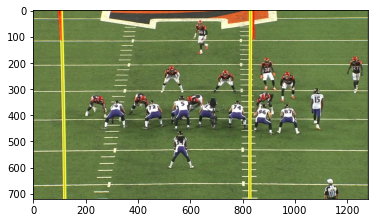

In [8]:
video_file = '/kaggle/input/nfl-impact-detection/train/57583_000082_Endzone.mp4'

cap = cv2.VideoCapture(video_file)

frames = []
while True:
    has_frame, image = cap.read()
    
    if has_frame:
        image = image[:, :, ::-1] # convert BGR -> RGB
        frames.append(image)
    else:
        break
frames = np.stack(frames, axis=0)

print(f'frame shape: {frames.shape}')    
plt.imshow(frames[0])

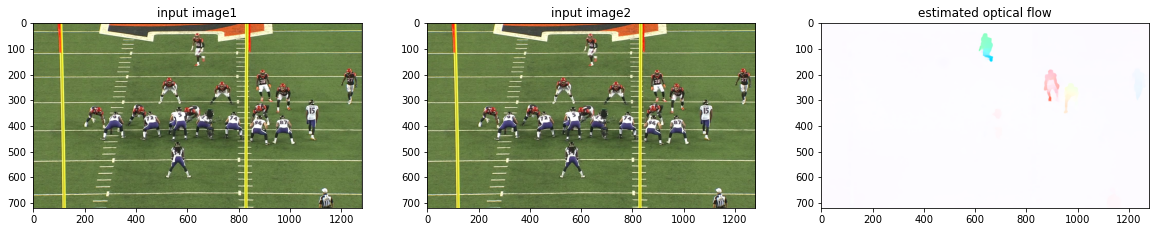

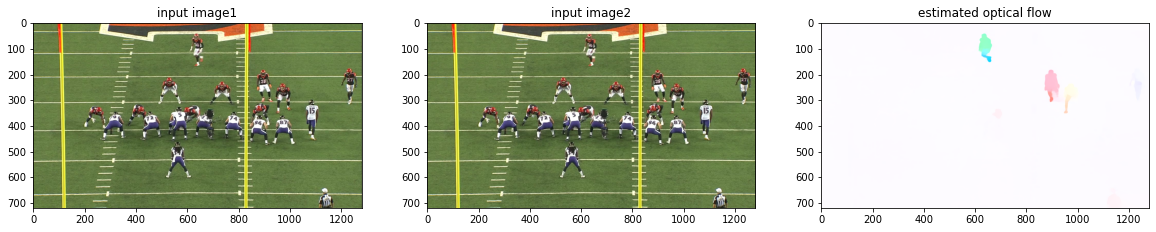

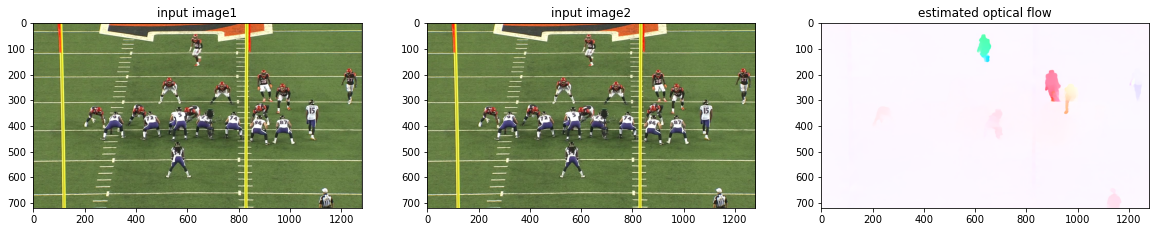

In [9]:
n_vis = 3

for i in range(n_vis):
    image1 = torch.from_numpy(frames[i]).permute(2, 0, 1).float().to(device)
    image2 = torch.from_numpy(frames[i+1]).permute(2, 0, 1).float().to(device)
    
    image1 = image1[None].to(device)
    image2 = image2[None].to(device)

    padder = InputPadder(image1.shape)
    image1, image2 = padder.pad(image1, image2)
    
    with torch.no_grad():
        flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)
        
    viz(image1, image2, flow_up)

RAFT seems to capture the motion of each player.